# Exploratory Data Analysis
In this notebook, we conduct traditional data analysis to understand the nature of the data.



In [77]:
# Import relevant libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Load the data
crime_data = gpd.read_file('../dataset/ALL 2023 AND UNTIL JAN29 2024.geojson')
crime_data.crs = 'EPSG:3857'# CRS represents the coordinate system. crime_data initally is set to have CRS of EPSG:4326 but this is actually wrong. Here I set the CRS to be the correct one.
crime_data = crime_data.to_crs(epsg=4326) # change the coordinate system to EPSG:4326 or (longitude, latitude). Geocoder only accepts (long, lat).
crime_data

CREATE_TIME_INCIDENT                  LOCATION_TEXT BEAT REPORT_NUMBER  \
0       2024-01-03 07:33:12                  DUNKIN DONUTS  SW1          None   
1       2024-01-03 11:52:40                           None  SE1          None   
2       2024-01-03 11:53:16         ST PHILLIPS AME CHURCH  NE1          None   
3       2024-01-03 15:06:07                           None  SW3          None   
4       2024-01-03 15:15:23  CANOPY OAKS ELEMENTARY SCHOOL  NW1          None   
...                     ...                            ...  ...           ...   
161193  2023-12-26 22:35:06           VENETIAN VILLAS APTS   14          None   
161194  2023-12-26 05:55:10                    ACTS CHURCH  NW1          None   
161195  2023-12-26 06:10:36                           None  NW1          None   
161196  2023-12-26 14:14:51                           None  NE1          None   
161197  2023-12-26 19:11:29                           None  SW1          None   

       LEGEND2          DISPO_TEXT OBJECTID                    geometry  
0          505  COMMUNITY POLICING        1  POINT (-84.34536 30.45588)  
1          505  COMMUNITY POLICING        2  POINT (-84.25513 30.33586)  
2          505  COMMUNITY POLICING        3  POINT (-84.17594 30.53916)  
3          145       THEFT - GRAND        4  POINT (-84.30023 30.37559)  
4          505  COMMUNITY POLICING        5  POINT (-84.34680 30.51014)  
...        ...                 ...      ...                         ...  
161193     505  COMMUNITY POLICING   149211  POINT (-84.31701 30.43925)  
161194     505  COMMUNITY POLICING   149212  POINT (-84.32834 30.50324)  
161195     504  COMMUNITY POLICING   149213  POINT (-84.28069 30.49272)  
161196     159   MISC SERVICE CALL   149214  POINT (-84.14430 30.56960)  
161197     133  LOUD NOISE / MUSIC   149215  POINT (-84.39811 30.43826)  

[161198 rows x 8 columns]

# Categorical Analysis

## Types of Reports
As the data above shows, we have mainly 4 important columns: The time the crime report ocurred (`CREATE_TIME_INCIDENT`), the location name of the report (`LOCATION_TEXT`), the type of the report `DISPO_TEXT` and the geographical coordinate of the report (`geometry`). First, we will focus on `DISPO_TEXT` and see how many reports each type of report have.

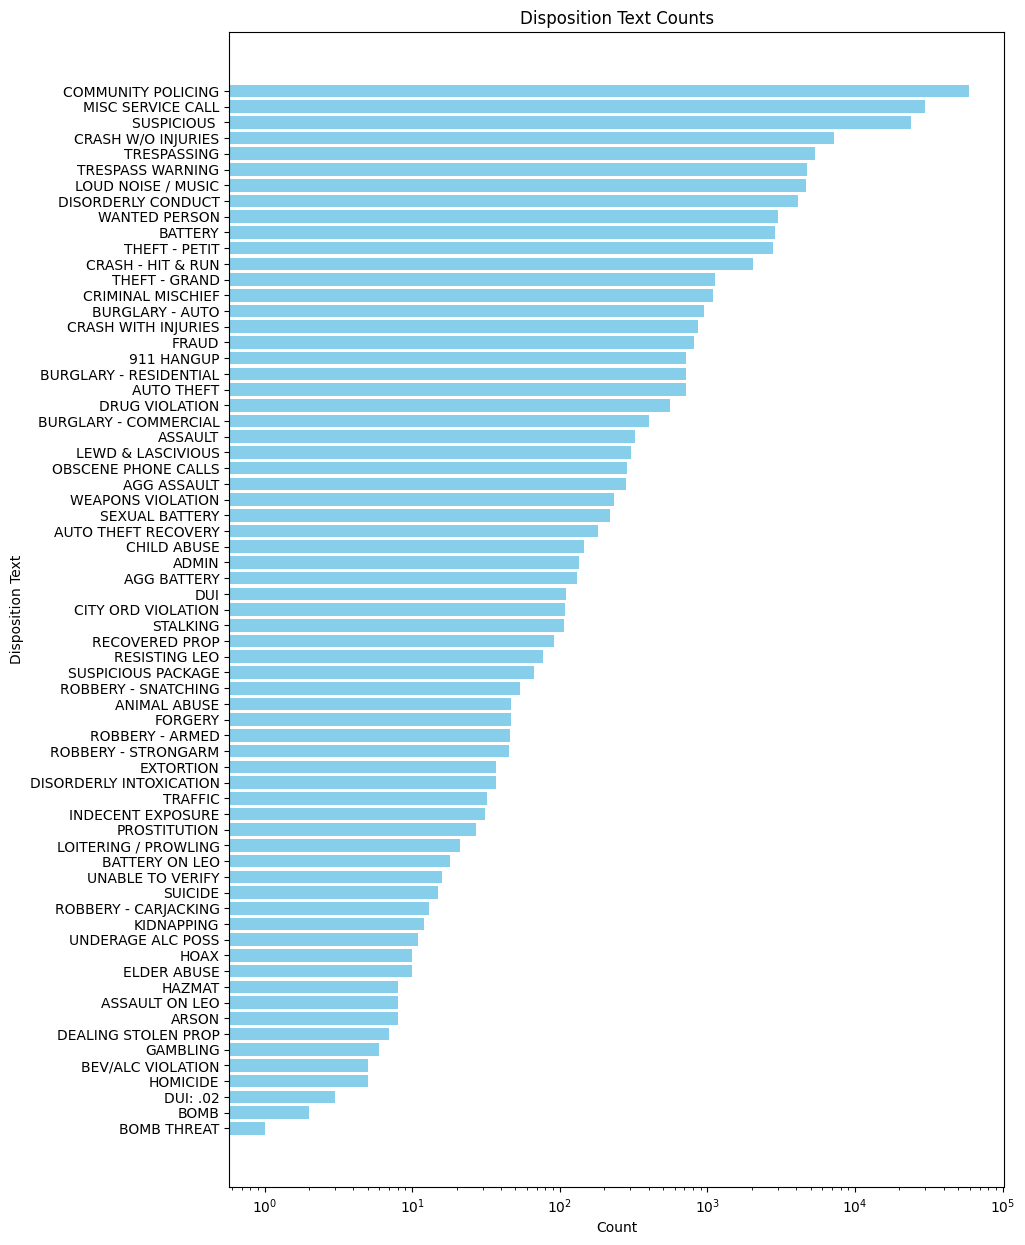

In [8]:
# Count the number of occurrences of each unique value in the 'DISPO_TEXT' column
s = crime_data['DISPO_TEXT'].value_counts()

# Convert the series to a DataFrame and reset the index
df = s.reset_index()
df.columns = ['DISPO_TEXT', 'count']  # Rename the columns appropriately


# Sort the DataFrame by count to make the chart easier to read
df_sorted = df.sort_values(by="count", ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 15))
plt.barh(df_sorted['DISPO_TEXT'], df_sorted['count'], color='skyblue')
plt.xscale('log')
plt.xlabel('Count')
plt.ylabel('Disposition Text')
plt.title('Disposition Text Counts')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

We notice that `COMMUNITY POLICING` has the highest count, which is not really a crime report. We will take care of non-crime reports later. What caught our mind was that there is a report for `BOMB` or `BOMB_THREAT`. We wanted to know when it occured. The following result shows it happened early 2024, but we could not find more detailed information regarding the incident.

In [10]:
# Finding when `BOMB` ocurred
index_when = df[df['DISPO_TEXT'] == 'BOMB'].index.tolist()
index_when_threat = indices = df[df['DISPO_TEXT'] == 'BOMB THREAT'].index.tolist()
# Outputs dates when bomb was reported
print(crime_data.iloc[index_when]['CREATE_TIME_INCIDENT'])
print(crime_data.iloc[index_when_threat]['CREATE_TIME_INCIDENT'])

65   2024-01-03 18:08:00
Name: CREATE_TIME_INCIDENT, dtype: datetime64[ns]
66   2024-01-03 18:09:30
Name: CREATE_TIME_INCIDENT, dtype: datetime64[ns]


## Locations
Many reports have the location information available, so it would be interesting to see where it occured. Due to the number of different locations, we only plot the top 50 locations.

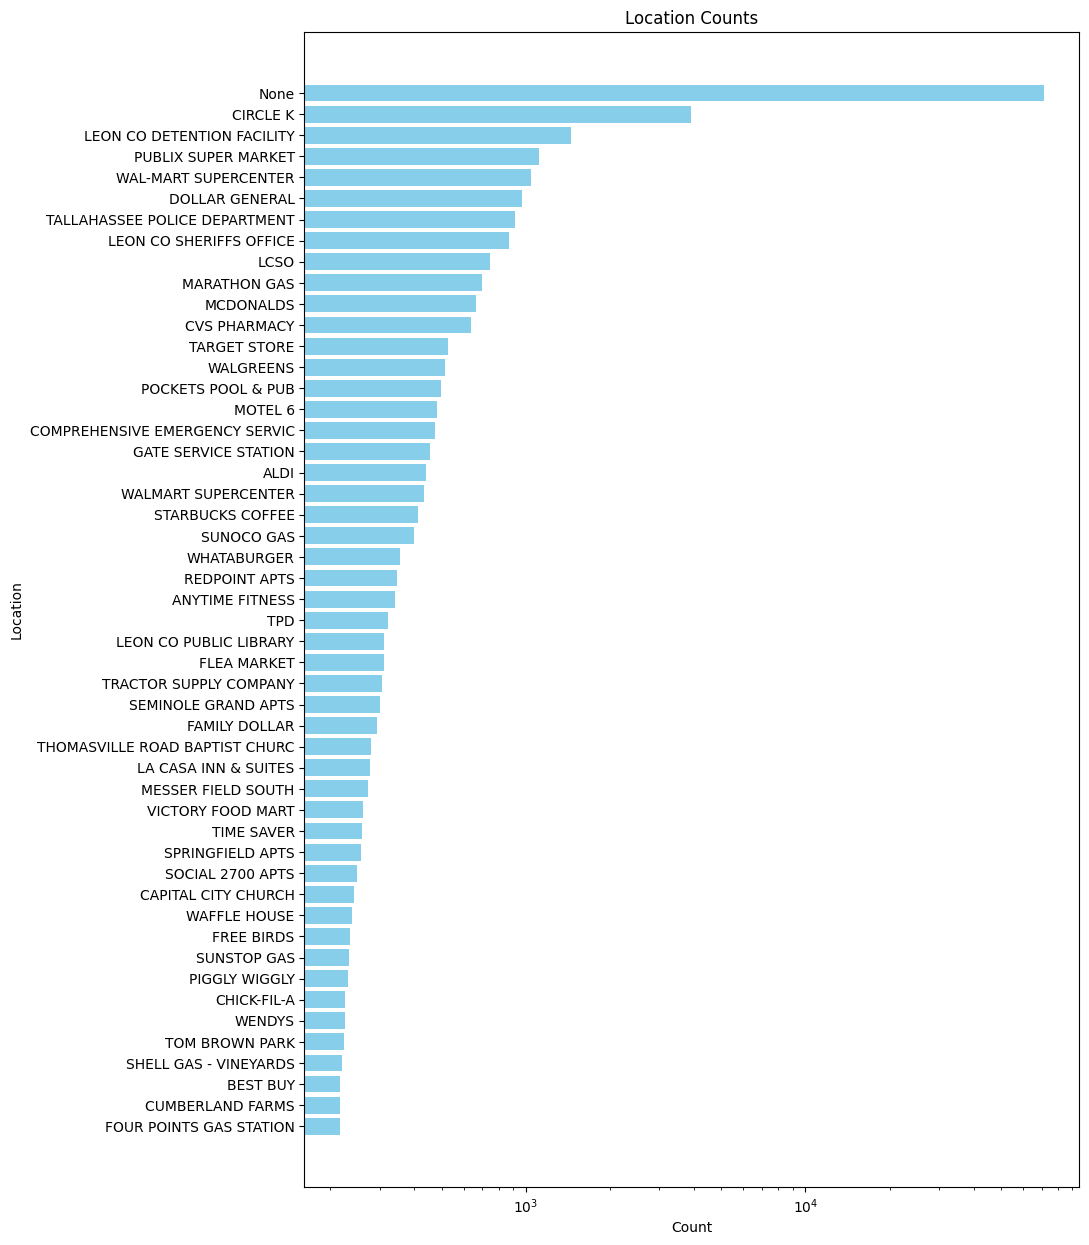

In [13]:
# Let's assume 's' is the series obtained from value_counts()
s_loc = crime_data['LOCATION_TEXT'].value_counts()

# Convert the series to a DataFrame and reset the index
df = s_loc.reset_index()
df.columns = ['LOCATION_TEXT', 'count']  # Rename the columns appropriately

# Sort the DataFrame by count to make the chart easier to read
df_sorted = df.sort_values(by="count", ascending=False)

# Plotting the bar chart
plt.figure(figsize=(10, 15))
plt.barh(df_sorted['LOCATION_TEXT'][:50], df_sorted['count'][:50], color='skyblue')
plt.xscale('log')
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Location Counts')
plt.gca().invert_yaxis()  # To display the highest count at the top
plt.show()

We observe that restaurants, shopping centers and gas stations are the most common places, which is not so surprising as they gather many people. In particular, Circle K seems to be the most dangerous place. To investigate Cirle K further, we will find the number of reports per location. To compare it with other tenants, we took Publix and Walmart and the following is the result.

In [39]:
df_three_locations = df_sorted[df_sorted['LOCATION_TEXT'].isin(['CIRCLE K','PUBLIX SUPER MARKET', 'WAL-MART SUPERCENTER'])].copy()
location_data = [23, 13, 5] # Manually counted
df_three_locations["locations"] = location_data
df_three_locations["Normalized Count"] = df_three_locations["count"] / df_three_locations["locations"]
df_three_locations

LOCATION_TEXT  count  locations  Normalized Count
1              CIRCLE K   3900         23        169.565217
3   PUBLIX SUPER MARKET   1113         13         85.615385
4  WAL-MART SUPERCENTER   1047          5        209.400000

We observe that the normalized count is higher for Walmart, although it is still high for Circle K.

## Unwanted Categories and Locations
As mentioned earlier, many reports are concentrated to `COMMUNITY POLICING` for report types and law enforcement facilities such as `LEON CO DETENTION FACILITY`. We will investigate if there are any other report types or locations that might skew the result.


In [ ]:
# printing all report types
crime_data['DISPO_TEXT'].unique()

array(['COMMUNITY POLICING', 'THEFT - GRAND', 'CRASH W/O INJURIES',
       '911 HANGUP', 'OBSCENE PHONE CALLS', 'MISC SERVICE CALL', 'FRAUD',
       'BATTERY', 'LOUD NOISE / MUSIC', 'SUSPICIOUS ', 'TRESPASS WARNING',
       'BURGLARY - COMMERCIAL', 'DISORDERLY CONDUCT', 'TRESPASSING',
       'CRASH - HIT & RUN', 'WANTED PERSON', 'CRIMINAL MISCHIEF',
       'AGG BATTERY', 'THEFT - PETIT', 'CITY ORD VIOLATION',
       'RECOVERED PROP', 'AUTO THEFT', 'AGG ASSAULT',
       'BURGLARY - RESIDENTIAL', 'SUSPICIOUS PACKAGE',
       'WEAPONS VIOLATION', 'CRASH WITH INJURIES', 'ROBBERY - ARMED',
       'FORGERY', 'BURGLARY - AUTO', 'ASSAULT', 'LEWD & LASCIVIOUS',
       'ELDER ABUSE', 'DRUG VIOLATION', 'ADMIN', 'ROBBERY - SNATCHING',
       'ANIMAL ABUSE', 'AUTO THEFT RECOVERY', 'EXTORTION',
       'SEXUAL BATTERY', 'RESISTING LEO', 'HOAX', 'ASSAULT ON LEO', 'DUI',
       'STALKING', 'ROBBERY - STRONGARM', 'CHILD ABUSE',
       'DEALING STOLEN PROP', 'ARSON', 'KIDNAPPING',
       'LOITERING / PRO

As discussed earlier, we should remove "COMMUNITY POLICING" reports from our data.

In [ ]:
crime_data[crime_data['DISPO_TEXT'] == 'ADMIN']

CREATE_TIME_INCIDENT                   LOCATION_TEXT BEAT  \
736     2024-01-04 12:00:31    HARBOR CHASE ASSISTED LIVING    3   
2689    2024-01-10 12:51:04  WESTMINSTER GARDENS RETIREMENT    5   
3188    2024-01-11 15:42:01             EAGLES LANDING APTS    3   
3808    2024-01-13 15:39:19                            None   17   
4101    2024-01-14 10:53:31                            None    7   
...                     ...                             ...  ...   
157706  2023-12-23 09:11:50                            None    8   
157819  2023-12-23 18:47:59                            None    6   
160353  2024-01-02 14:04:57           WHISPERING PINES APTS    8   
160448  2023-12-25 13:57:12       PRUITT HEALTH - SOUTHWOOD  SE2   
160571  2023-12-25 14:47:02              TMH EMERGENCY ROOM  NE6   

        REPORT_NUMBER LEGEND2 DISPO_TEXT OBJECTID  \
736     2024-00002019     205      ADMIN      364   
2689    2024-00005621     205      ADMIN      141   
3188    2024-00006362     205      ADMIN      327   
3808    2024-00007675     205      ADMIN      251   
4101    2024-00008116     205      ADMIN      189   
...               ...     ...        ...      ...   
157706  2023-00220210     205      ADMIN   145724   
157819  2023-00220414     205      ADMIN   145837   
160353  2024-00000820     205      ADMIN   148371   
160448           None     205      ADMIN   148466   
160571           None     205      ADMIN   148589   

                                    geometry  
736     POINT (-9381781.66170 3564771.56660)  
2689    POINT (-9381895.60610 3561093.85150)  
3188    POINT (-9378519.88820 3567484.71950)  
3808    POINT (-9388579.24170 3565608.67230)  
4101    POINT (-9381720.07090 3556739.45580)  
...                                      ...  
157706  POINT (-9379806.18830 3556725.81330)  
157819  POINT (-9370852.12380 3563725.38310)  
160353  POINT (-9378492.37890 3557880.38590)  
160448  POINT (-9376381.38620 3556967.18930)  
160571  POINT (-9379896.35930 3562582.00810)  

[136 rows x 8 columns]

The category "ADMIN" is not on TOPS's legend for report, so these reports are not informative. I suggest removing them.

In [ ]:
crime_data[crime_data['DISPO_TEXT'] == 'RECOVERED PROP']

CREATE_TIME_INCIDENT             LOCATION_TEXT BEAT  REPORT_NUMBER  \
153     2024-01-03 02:13:55                      None    7           None   
588     2024-01-04 08:58:06                      None  SE3           None   
1426    2024-01-06 17:44:22  EXTENDED STAY OF AMERICA   17           None   
1698    2024-01-06 17:44:22  EXTENDED STAY OF AMERICA   17           None   
3843    2024-01-13 16:52:33                      None  SE1           None   
...                     ...                       ...  ...            ...   
152990  2023-12-06 18:48:27                      None    3  2023-00210589   
153926  2023-12-05 11:34:53                      None    3           None   
156613  2023-12-24 18:36:45    TAPESTRY SENIOR LIVING    3           None   
159984  2024-01-01 18:18:45                      LCSO  SW2           None   
160681  2024-01-01 15:53:34                      None  NW2           None   

       LEGEND2      DISPO_TEXT OBJECTID                              geometry  
153        135  RECOVERED PROP      154  POINT (-9381468.16380 3559942.90160)  
588        135  RECOVERED PROP      216  POINT (-9382361.93460 3556657.47020)  
1426       135  RECOVERED PROP      226  POINT (-9391615.01220 3562531.12790)  
1698       135  RECOVERED PROP      170  POINT (-9391615.01220 3562531.12790)  
3843       135  RECOVERED PROP      286  POINT (-9378759.43660 3543816.14300)  
...        ...             ...      ...                                   ...  
152990     135  RECOVERED PROP   141008  POINT (-9381896.59240 3562588.94940)  
153926     135  RECOVERED PROP   141944  POINT (-9381896.59240 3562588.94940)  
156613     135  RECOVERED PROP   144631  POINT (-9384576.80730 3565250.17310)  
159984     135  RECOVERED PROP   148002  POINT (-9388144.99110 3560171.15910)  
160681     135  RECOVERED PROP   148699  POINT (-9386452.80340 3562132.39610)  

[91 rows x 8 columns]

The category "RECOVERED PROP" represents "Items reported as stolen and located or recovered by law enforcement" according to the TOPS legend, so I don't think we should have this in our crime data. The same goes for 'AUTO THEFT RECOVERY'.

In [ ]:
crime_data[crime_data['DISPO_TEXT'] == 'UNABLE TO VERIFY']

CREATE_TIME_INCIDENT                   LOCATION_TEXT BEAT  \
7636    2024-01-25 05:33:16  GREENS AT OLD ST AUGUSTINE APT    8   
24606   2023-02-23 09:37:41                            None    7   
26191   2023-02-08 04:35:57         TERRA LAKE HEIGHTS APTS    3   
27108   2023-01-06 08:46:58                            None    3   
37454   2023-03-01 19:46:41              OREILLY AUTO PARTS    8   
39775   2023-03-04 18:07:24                            None    6   
44657   2023-03-29 21:12:54                            None   10   
47516   2023-04-05 23:21:06                   FAMILY DOLLAR    7   
50318   2023-03-04 10:55:18                            None  NW1   
66845   2023-05-31 06:02:40                  HOWARD JOHNSON    3   
75641   2023-06-01 12:58:52             PUBLIX SUPER MARKET    7   
91592   2023-07-16 01:40:22                            None   17   
107865  2023-08-21 19:08:24                            None    2   
113117  2023-08-19 13:32:38              URBAN ENCLAVE APTS   10   
156167  2023-12-04 18:17:41                            None  SW2   
160680  2024-01-01 08:32:44                            None  NE1   

        REPORT_NUMBER LEGEND2        DISPO_TEXT OBJECTID  \
7636             None     155  UNABLE TO VERIFY      235   
24606            None     155  UNABLE TO VERIFY    12624   
26191            None     155  UNABLE TO VERIFY    14209   
27108            None     155  UNABLE TO VERIFY    15126   
37454   2023-00038704     155  UNABLE TO VERIFY    25472   
39775            None     155  UNABLE TO VERIFY    27793   
44657            None     155  UNABLE TO VERIFY    32675   
47516            None     155  UNABLE TO VERIFY    35534   
50318            None     155  UNABLE TO VERIFY    38336   
66845            None     155  UNABLE TO VERIFY    54863   
75641            None     155  UNABLE TO VERIFY    63659   
91592            None     155  UNABLE TO VERIFY    79610   
107865           None     155  UNABLE TO VERIFY    95883   
113117  2023-00144290     155  UNABLE TO VERIFY   101135   
156167           None     155  UNABLE TO VERIFY   144185   
160680           None     155  UNABLE TO VERIFY   148698   

                                    geometry  
7636    POINT (-9378239.56240 3558303.68960)  
24606   POINT (-9380291.83510 3558269.35240)  
26191   POINT (-9384960.43990 3565006.68650)  
27108   POINT (-9384821.51540 3564775.71540)  
37454   POINT (-9377577.90270 3558856.46870)  
39775   POINT (-9376434.47450 3563369.56700)  
44657   POINT (-9383784.82920 3558847.99560)  
47516   POINT (-9382162.70610 3554645.04600)  
50318   POINT (-9383658.49390 3568776.51250)  
66845   POINT (-9384392.25300 3565238.12810)  
75641   POINT (-9383292.48540 3551638.52830)  
91592   POINT (-9389568.73400 3566198.20690)  
107865  POINT (-9377080.51940 3569401.53240)  
113117  POINT (-9383913.32640 3559379.92440)  
156167  POINT (-9387211.72180 3560189.14880)  
160680  POINT (-9372655.96040 3573397.93760)

The category "UNABLE TO VERIFY" is for reports where officers could not locate the incident. We should remove this.

In [ ]:
crime_data[crime_data['DISPO_TEXT'] == 'TRAFFIC']

CREATE_TIME_INCIDENT          LOCATION_TEXT  BEAT  REPORT_NUMBER  \
3708    2024-01-13 02:46:51         GLEN OAKS APTS     8           None   
12397   2023-02-23 14:54:33                   None   NE5           None   
13173   2023-01-21 12:34:24           TARGET STORE   NE1           None   
18965   2023-01-26 17:01:30                   None   NE1           None   
26422   2023-02-02 17:14:34                   None   NW1           None   
28166   2023-01-03 22:38:46                   None    13  2023-00001720   
29452   2023-01-13 21:48:49                   None     2           None   
30866   2023-01-20 03:15:53       SPRINGFIELD APTS    18           None   
37018   2023-01-05 04:55:50                   None   SW2           None   
37112   2023-01-04 17:16:07                   None   SE2           None   
39448   2023-03-06 15:42:04                   None     5           None   
42335   2023-03-15 06:45:45                   None     3           None   
45260   2023-04-04 17:02:53                   None   NW1           None   
52208   2023-02-15 08:38:23                   None   NE1           None   
52347   2023-02-17 17:35:06                   None   NE5           None   
66687   2023-04-23 22:01:24                   None   SW2           None   
71468   2023-05-25 11:59:19                   None   NE6           None   
72268   2023-05-26 10:50:58                   None     4           None   
73772   2023-05-18 19:12:05                   None   NW1           None   
77897   2023-06-09 23:10:36                   None    10           None   
80218   2023-06-20 22:12:06  SEMINOLE TERRACE APTS    16  2023-00107341   
87086   2023-06-28 08:51:27                   None   NE1           None   
95667   2023-07-22 22:44:34                   None     7           None   
96349   2023-08-09 02:55:18                   None    11           None   
103212  2023-08-15 13:20:58                   None   NE6           None   
112900  2023-08-07 09:40:27                   None   NE6           None   
125999  2023-10-06 23:35:53                   None    10           None   
131489  2023-10-11 07:47:25                   None  None           None   
138068  2023-10-27 16:05:56                   None     7           None   
139326  2023-11-16 11:00:16                   None   NE6           None   
141106  2023-10-13 18:54:57                   None   NW2           None   
158743  2023-12-27 20:23:20                   None    16           None   

       LEGEND2 DISPO_TEXT OBJECTID                              geometry  
3708       323    TRAFFIC      151  POINT (-9377104.70130 3557319.65530)  
12397      323    TRAFFIC      415  POINT (-9374495.76210 3572704.03250)  
13173      323    TRAFFIC     1191  POINT (-9374749.09070 3575875.28950)  
18965      323    TRAFFIC     6983  POINT (-9379284.79670 3573929.34610)  
26422      323    TRAFFIC    14440  POINT (-9386948.98670 3567060.37160)  
28166      323    TRAFFIC    16184  POINT (-9387130.36070 3556689.79460)  
29452      323    TRAFFIC    17470  POINT (-9376568.01450 3572673.56050)  
30866      323    TRAFFIC    18884  POINT (-9384580.05230 3562873.24510)  
37018      323    TRAFFIC    25036  POINT (-9388085.34940 3556910.59150)  
37112      323    TRAFFIC    25130  POINT (-9363934.08380 3557989.85190)  
39448      323    TRAFFIC    27466  POINT (-9381397.51150 3561312.55890)  
42335      323    TRAFFIC    30353  POINT (-9378882.94340 3568207.78960)  
45260      323    TRAFFIC    33278  POINT (-9391071.17190 3567015.47280)  
52208      323    TRAFFIC    40226  POINT (-9375070.14170 3575879.56090)  
52347      323    TRAFFIC    40365  POINT (-9375376.67330 3573213.34220)  
66687      323    TRAFFIC    54705  POINT (-9386767.92780 3554116.91640)  
71468      323    TRAFFIC    59486  POINT (-9376027.95470 3565469.34800)  
72268      323    TRAFFIC    60286  POINT (-9380143.34720 3563657.81440)  
73772      323    TRAFFIC    61790  POINT (-9387480.47720 3568303.97460)  
77897      323    TRAFFIC    65

"TRAFFIC" is another category without explanation in TOPS. Since this is uninformative we should remove this.

### Summary
In short, we should not include reports under these categories: "COMMUNITY POLICING", "ADMIN", "RECOVERED PROP", "AUTO THEFT RECOVERY", "UNABLE TO VERIFY" and "TRAFFIC". The following is a Python list for easy copy paste.

In [ ]:
unwanted_categories = ["COMMUNITY POLICING", "ADMIN", "RECOVERED PROP", "AUTO THEFT RECOVERY","UNABLE TO VERIFY", "TRAFFIC"]

The following shows how to get a dataframe without these categories.

In [ ]:
filtered_df = crime_data[~crime_data['DISPO_TEXT'].isin(unwanted_categories)]
filtered_df

CREATE_TIME_INCIDENT               LOCATION_TEXT BEAT  REPORT_NUMBER  \
3       2024-01-03 15:06:07                        None  SW3           None   
10      2024-01-03 12:56:08         PUBLIX SUPER MARKET   15  2024-00001415   
11      2024-01-03 12:59:24  POPEYES CHICKEN & BISCUITS    8  2024-00001416   
12      2024-01-03 13:00:33                        None    8           None   
13      2024-01-03 15:20:15                        None   17           None   
...                     ...                         ...  ...            ...   
161188  2023-12-26 16:32:21    EVERGREENS AT MAHAN APTS    6           None   
161189  2023-12-26 16:38:28                        None    6           None   
161191  2023-12-26 19:47:27       2305 AT KILLEARN APTS    2           None   
161196  2023-12-26 14:14:51                        None  NE1           None   
161197  2023-12-26 19:11:29                        None  SW1           None   

       LEGEND2           DISPO_TEXT OBJECTID  \
3          145        THEFT - GRAND        4   
10         145        THEFT - GRAND       11   
11         301   CRASH W/O INJURIES       12   
12         157           911 HANGUP       13   
13         129  OBSCENE PHONE CALLS       14   
...        ...                  ...      ...   
161188     159    MISC SERVICE CALL   149206   
161189     159    MISC SERVICE CALL   149207   
161191     133   LOUD NOISE / MUSIC   149209   
161196     159    MISC SERVICE CALL   149214   
161197     133   LOUD NOISE / MUSIC   149215   

                                    geometry  
3       POINT (-9384258.65290 3551920.61570)  
10      POINT (-9382518.93070 3563151.34570)  
11      POINT (-9376213.56100 3558603.68790)  
12      POINT (-9377965.56840 3557051.41780)  
13      POINT (-9389568.73400 3566198.20690)  
...                                      ...  
161188  POINT (-9377109.67950 3562229.97840)  
161189  POINT (-9375633.24020 3562987.91650)  
161191  POINT (-9377809.96600 3568400.03380)  
161196  POINT (-9366901.03320 3576978.28410)  
161197  POINT (-9395155.10670 3560009.27020)  

[101475 rows x 8 columns]

### Law Enforcement Facilities

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='LEON CO DETENTION FACILITY']['DISPO_TEXT'].value_counts()

DISPO_TEXT
WANTED PERSON              1241
BATTERY                      88
RESISTING LEO                51
MISC SERVICE CALL            29
DISORDERLY INTOXICATION       7
BATTERY ON LEO                5
LEWD & LASCIVIOUS             4
EXTORTION                     3
THEFT - GRAND                 3
OBSCENE PHONE CALLS           3
DRUG VIOLATION                3
CRASH W/O INJURIES            3
SUICIDE                       2
FORGERY                       2
FRAUD                         1
DEALING STOLEN PROP           1
ASSAULT ON LEO                1
CRIMINAL MISCHIEF             1
AUTO THEFT                    1
TRESPASSING                   1
SUSPICIOUS                    1
Name: count, dtype: int64

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='TALLAHASSEE POLICE DEPARTMENT']['DISPO_TEXT'].value_counts()

DISPO_TEXT
MISC SERVICE CALL         474
SUSPICIOUS                129
COMMUNITY POLICING         75
DRUG VIOLATION             43
FRAUD                      32
THEFT - PETIT              19
WANTED PERSON              16
THEFT - GRAND              15
AUTO THEFT RECOVERY        14
CRASH - HIT & RUN          11
BATTERY                    10
CRASH W/O INJURIES         10
SEXUAL BATTERY              6
AUTO THEFT                  6
OBSCENE PHONE CALLS         6
BURGLARY - AUTO             5
CRIMINAL MISCHIEF           5
RECOVERED PROP              5
DISORDERLY CONDUCT          4
LEWD & LASCIVIOUS           3
CHILD ABUSE                 3
ASSAULT                     3
SUSPICIOUS PACKAGE          2
WEAPONS VIOLATION           2
AGG BATTERY                 2
FORGERY                     2
BURGLARY - RESIDENTIAL      2
STALKING                    2
EXTORTION                   2
LOUD NOISE / MUSIC          1
CRASH WITH INJURIES         1
ROBBERY - ARMED             1
HOMICIDE                    1

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='LCSO']['DISPO_TEXT'].value_counts()

DISPO_TEXT
MISC SERVICE CALL      687
SUSPICIOUS              15
THEFT - GRAND            5
FRAUD                    5
OBSCENE PHONE CALLS      4
THEFT - PETIT            4
WANTED PERSON            3
RECOVERED PROP           3
BURGLARY - AUTO          2
LOUD NOISE / MUSIC       2
FORGERY                  1
CRASH W/O INJURIES       1
AGG ASSAULT              1
CRIMINAL MISCHIEF        1
SEXUAL BATTERY           1
ANIMAL ABUSE             1
CRASH - HIT & RUN        1
AUTO THEFT RECOVERY      1
BATTERY                  1
EXTORTION                1
AUTO THEFT               1
CHILD ABUSE              1
Name: count, dtype: int64

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='TPD']['DISPO_TEXT'].value_counts()

DISPO_TEXT
MISC SERVICE CALL      180
SUSPICIOUS              35
AUTO THEFT RECOVERY     20
THEFT - GRAND           19
THEFT - PETIT            9
RECOVERED PROP           9
SEXUAL BATTERY           7
OBSCENE PHONE CALLS      6
FRAUD                    5
BURGLARY - AUTO          4
CRASH - HIT & RUN        4
WANTED PERSON            3
COMMUNITY POLICING       3
AUTO THEFT               3
CRASH W/O INJURIES       3
STALKING                 2
ASSAULT                  2
BATTERY                  2
DRUG VIOLATION           1
ELDER ABUSE              1
ROBBERY - SNATCHING      1
TRESPASSING              1
DISORDERLY CONDUCT       1
Name: count, dtype: int64

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='LEON CO SHERIFFS OFFICE']['DISPO_TEXT'].value_counts()

DISPO_TEXT
MISC SERVICE CALL        745
SUSPICIOUS                33
FRAUD                     24
WANTED PERSON             12
LEWD & LASCIVIOUS          9
THEFT - GRAND              8
COMMUNITY POLICING         5
BATTERY                    4
CRASH W/O INJURIES         3
CRASH - HIT & RUN          3
DRUG VIOLATION             2
AUTO THEFT                 2
AGG ASSAULT                2
ASSAULT                    2
EXTORTION                  2
SEXUAL BATTERY             2
THEFT - PETIT              2
RECOVERED PROP             1
ROBBERY - CARJACKING       1
CRIMINAL MISCHIEF          1
FORGERY                    1
STALKING                   1
CHILD ABUSE                1
BURGLARY - COMMERCIAL      1
PROSTITUTION               1
Name: count, dtype: int64

In [ ]:
crime_data[crime_data['LOCATION_TEXT']=='IMMIGRATION & CUSTOMS ENFORCEM']['DISPO_TEXT'].value_counts()

DISPO_TEXT
LEWD & LASCIVIOUS     174
COMMUNITY POLICING      2
MISC SERVICE CALL       1
DRUG VIOLATION          1
Name: count, dtype: int64

### Suggestion

It seems that wide variety of reports are concentrated at law enforcement facilities. Although we wouldn't check with TPD, it is possibly because they are where enforcement officers received the report. That is, they are not the location of the incident, rather where the incident report was received.

Following this hypothesis, we suggest to not use data at LE facilities for `pix2pix`, but I believe using them for statistical analysis not involving the location of the crime is fine.

The following is how to remove these reports from our dataframe.

In [ ]:
unwanted_locations = ['LEON CO DETENTION FACILITY', 'TALLAHASSEE POLICE DEPARTMENT', 'LCSO', 'TPD', 'LEON CO SHERIFFS OFFICE', 'IMMIGRATION & CUSTOMS ENFORCEM']
location_filtered_crime_data = crime_data[~crime_data['LOCATION_TEXT'].isin(unwanted_locations)]
location_filtered_crime_data

CREATE_TIME_INCIDENT                  LOCATION_TEXT BEAT REPORT_NUMBER  \
0       2024-01-03 07:33:12                  DUNKIN DONUTS  SW1          None   
1       2024-01-03 11:52:40                           None  SE1          None   
2       2024-01-03 11:53:16         ST PHILLIPS AME CHURCH  NE1          None   
3       2024-01-03 15:06:07                           None  SW3          None   
4       2024-01-03 15:15:23  CANOPY OAKS ELEMENTARY SCHOOL  NW1          None   
...                     ...                            ...  ...           ...   
161193  2023-12-26 22:35:06           VENETIAN VILLAS APTS   14          None   
161194  2023-12-26 05:55:10                    ACTS CHURCH  NW1          None   
161195  2023-12-26 06:10:36                           None  NW1          None   
161196  2023-12-26 14:14:51                           None  NE1          None   
161197  2023-12-26 19:11:29                           None  SW1          None   

       LEGEND2          DISPO_TEXT OBJECTID  \
0          505  COMMUNITY POLICING        1   
1          505  COMMUNITY POLICING        2   
2          505  COMMUNITY POLICING        3   
3          145       THEFT - GRAND        4   
4          505  COMMUNITY POLICING        5   
...        ...                 ...      ...   
161193     505  COMMUNITY POLICING   149211   
161194     505  COMMUNITY POLICING   149212   
161195     504  COMMUNITY POLICING   149213   
161196     159   MISC SERVICE CALL   149214   
161197     133  LOUD NOISE / MUSIC   149215   

                                    geometry  
0       POINT (-9389282.40800 3562284.73410)  
1       POINT (-9379238.14610 3546795.25590)  
2       POINT (-9370422.79120 3573044.32780)  
3       POINT (-9384258.65290 3551920.61570)  
4       POINT (-9389443.01420 3569293.67900)  
...                                      ...  
161193  POINT (-9386126.17420 3560137.28670)  
161194  POINT (-9387388.17550 3568401.81670)  
161195  POINT (-9382084.01440 3567042.38750)  
161196  POINT (-9366901.03320 3576978.28410)  
161197  POINT (-9395155.10670 3560009.27020)  

[156722 rows x 8 columns]

The following is a code to remove all of the unwanted types or locations.

In [78]:
# Applying both filters
unwanted_locations = ['LEON CO DETENTION FACILITY', 'TALLAHASSEE POLICE DEPARTMENT', 'LCSO', 'TPD', 'LEON CO SHERIFFS OFFICE', 'IMMIGRATION & CUSTOMS ENFORCEM']
unwanted_categories = ["COMMUNITY POLICING", "ADMIN", "RECOVERED PROP", "AUTO THEFT RECOVERY","UNABLE TO VERIFY", "TRAFFIC"]
location_filtered_crime_data = crime_data[~crime_data['LOCATION_TEXT'].isin(unwanted_locations)]
location_filtered_crime_data
df = location_filtered_crime_data[~location_filtered_crime_data['DISPO_TEXT'].isin(unwanted_categories)]


# Temporal Analysis
We will focus on the time when the crime report happened. We will plot the cumulative sum of the number of reports for each hour/day/month/semester. Unless noted, we will use the filtered data processed above.

## Hourly Distribution

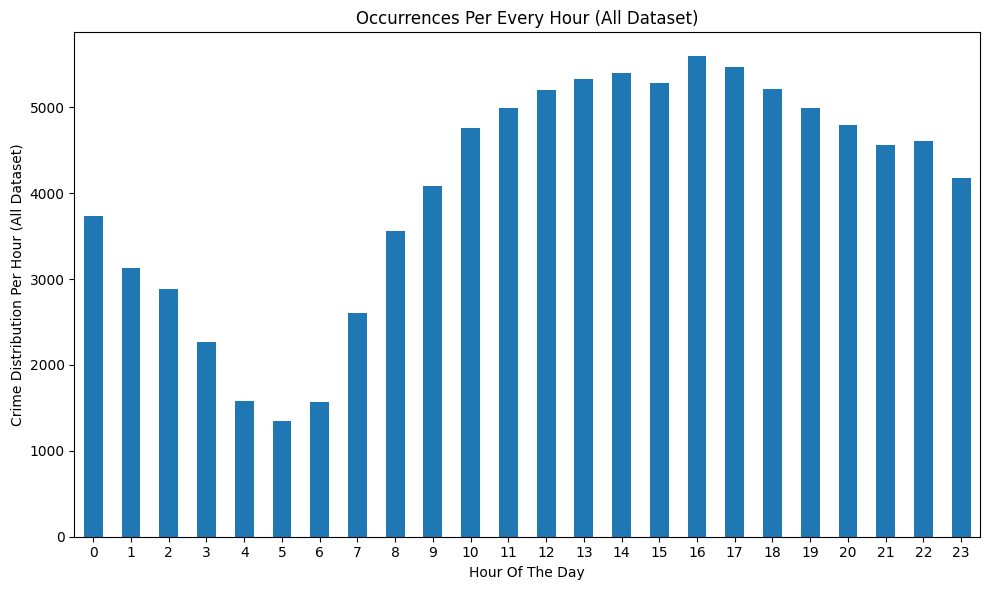

In [54]:
hourly_incidents = df['CREATE_TIME_INCIDENT'].dt.hour.value_counts().sort_index()
hourly_incidents
hourly_incidents.plot(kind = 'bar',figsize = (10,6))
plt.title('Occurrences Per Every Hour (All Dataset)')
plt.xlabel('Hour Of The Day')
plt.ylabel('Crime Distribution Per Hour (All Dataset)')

#file_path_name = './Figures/Crime Distribution Per Hour (All Dataset).png'
plt.xticks(rotation = 0)
plt.tight_layout()
#plt.savefig(file_path_name,bbox_inches = 'tight')
plt.show()

We note that it peaks at around 12 pm and it reaches the bottom at 6 am. This data could be helpful for law enforcement officers to schedule efficient patroling schedule.

## Day vs Night
We compare the difference between the numbeer of reports during the day (7 am - 6:59 pm) and the night (others). 

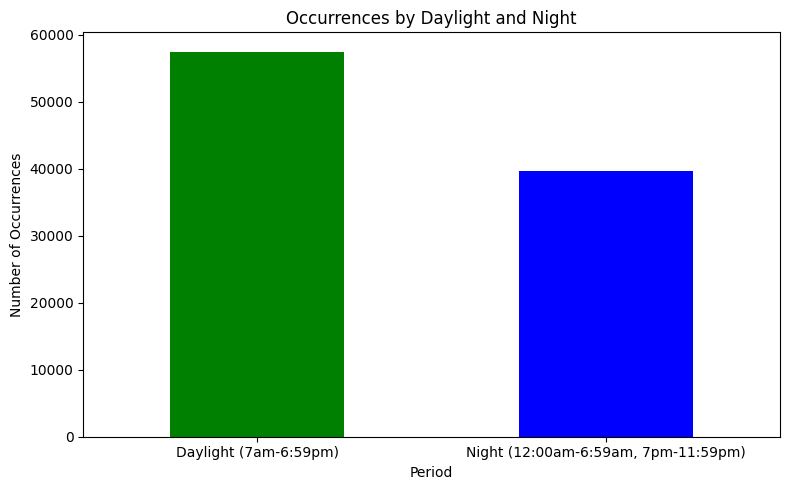

In [48]:
# Define a function that maps hours to 0 or 1 depending on whether there are in the daylight hours or night: Daylight == 0 , Night == 1
def map_hour_to_period(hour):
    if 0 <= hour <= 6 or 19 <= hour <= 23:
        return 1  # Night
    else:
        return 0  # Daylight

# Apply the function to each hour in the series
mapped_hours = df['CREATE_TIME_INCIDENT'].dt.hour.apply(map_hour_to_period)

# Count the number of occurrences of each period (0 or 1)
period_counts = mapped_hours.value_counts()

# Sort the index to ensure periods are in order (optional, for clarity)
period_counts = period_counts.sort_index()

# Plotting
period_counts.plot(kind='bar', figsize=(8, 5), color=['green', 'blue'])

plt.title('Occurrences by Daylight and Night')
plt.xlabel('Period')
plt.ylabel('Number of Occurrences')
plt.xticks(ticks=[0, 1], labels=['Daylight (7am-6:59pm)', 'Night (12:00am-6:59am, 7pm-11:59pm)'], rotation=0)

plt.tight_layout()
#file_path_name = './Figures/Daylight_and_Night.png'
#plt.savefig(file_path_name,bbox_inches = 'tight')

plt.show()


We again observe that there are less reports during the night.

## Days In A Week
We calcualte the cumulative sum of the numbers of reports for each day in a week. 

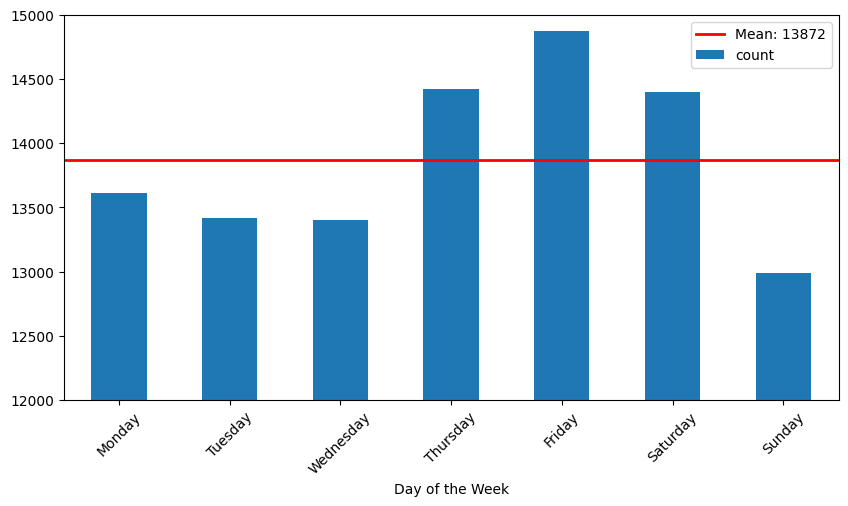

In [57]:
time_stamps = df['CREATE_TIME_INCIDENT']# Extract all time stamp objects
days = []
for date in time_stamps:
    x = datetime.weekday(date)
    days.append(x)

# make a copy of the dataset
days_of_the_week = df.copy()

# convert the timestamps into days of the week represented by 0,1,2,3,4,5,6
days_of_the_week['CREATE_TIME_INCIDENT']= days

# in fact change the name of the column to "Days indexed"
days_of_the_week.rename(columns={'CREATE_TIME_INCIDENT': 'Days Indexed'}, inplace=True)

# turn into pandas series object to get a count
# sort_index() ensures it isn't in descending order but it goes 0,1,2,3,4,5,6
series = days_of_the_week['Days Indexed'].value_counts().sort_index()

# Calculate mean
arr = np.array(series)
mean = int(np.mean(arr))

# to display the name of the day on the x-axis rather than the day index
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Replace the index of the series with day names
series.index = series.index.map(day_mapping)

plt.figure(figsize=(10,5))
series.plot(kind='bar')
# Add a red horizontal line to indicate the mean
plt.axhline(y = mean, color='r', linestyle='-', linewidth=2, label=f'Mean: {mean}')
plt.xticks(rotation = 45)
plt.ylim(12000,15000)
plt.xlabel('Day of the Week')
plt.legend()
plt.show()

We observe that the days before weekend tends to have more reports, while Sunday has the least.

## Monthly Distribution

We will now plot the monthly distribution.

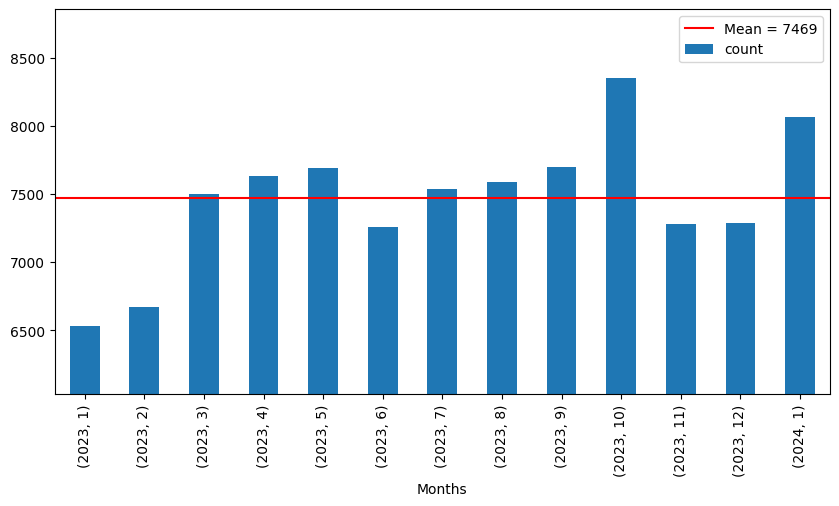

In [66]:
def HistogramMonthly(DataFrame,f = (15,7)):
    create_time_incident = DataFrame.columns[0] #This should be the Create Time Incident Column
    date_counts = DataFrame[create_time_incident].dt.date.value_counts() #Returns a series of time incident <--> number of occurences
    date_counts_sorted = date_counts.sort_index()#sorts it with respect to date
   # Convert the index to datetime to ensure proper grouping
    date_counts_sorted.index = pd.to_datetime(date_counts_sorted.index)
    # Group by year and month, and sum the counts for each month
    monthly_counts = date_counts_sorted.groupby([date_counts_sorted.index.year, date_counts_sorted.index.month]).sum()

    # Plotting the histogram with monthly bins
    monthly_counts.plot(kind='bar', figsize=f)


CTI = df['CREATE_TIME_INCIDENT'].dt.date.value_counts().sort_index()
CTI
CTI.index = pd.to_datetime(CTI.index) # This is needed to use resample method allowing us to resample dates by the day, week or month, year etc.
Monthly_CTI = CTI.resample('M').sum()
Monthly_mean = int(np.mean(Monthly_CTI)) #check the mean
# Number of incidents occured per month
f = (10,5)
HistogramMonthly(df,f)
plt.axhline(y = Monthly_mean,color='r',label=f'Mean = {Monthly_mean}')
plt.legend()
plt.xlabel('Months')
plt.ylim(np.min(Monthly_CTI)-500, np.max(Monthly_CTI)+500)
plt.show()

We observe an interesting phenomenon where January 2023 has the least number of reports while the January next year has the second most. Although we could not figure out the reason why this happened, it could just be a stochastic fluctuation.

## Semester by semester: Does the absense of students affect the number of reports?
We will now plot the number of reports by semester of FSU in 2023. The motivation is to find out if the absense of students can affect the number of reports.

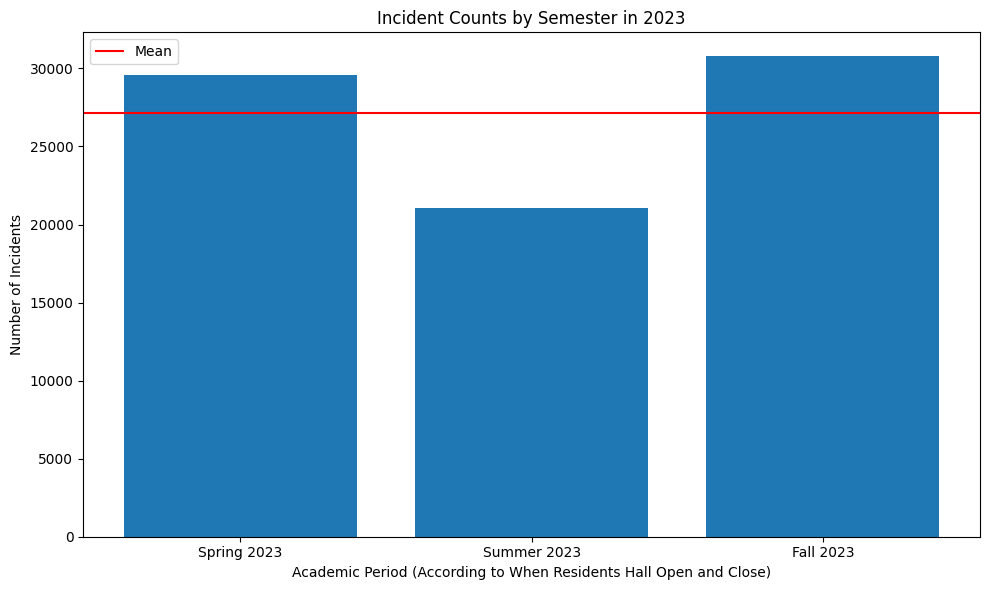

In [68]:
# Create the data for 2023
get_2023_index = df['CREATE_TIME_INCIDENT'].dt.year == 2023
df_2023 = df[get_2023_index].copy()

df_2023['CREATE_TIME_INCIDENT'] = pd.to_datetime(df_2023['CREATE_TIME_INCIDENT']).dt.date
time_stamps = df_2023['CREATE_TIME_INCIDENT']

dates = [time_stamps.iloc[i] for i in range(len(time_stamps))]

# Define your start and end dates of spring semester
# According to when the residents hall open and close
start_date_spring = pd.to_datetime('2023-01-05').date()
end_date_spring = pd.to_datetime('2023-05-06').date()
dates_in_spring = [date for date in dates if start_date_spring <= date <= end_date_spring]
count_dates_in_spring = len(dates_in_spring)
count_dates_in_spring

# Define your start and end dates of summer semester
# According to when the residents hall open and close
start_date_summer = pd.to_datetime('2023-05-11').date()
end_date_summer = pd.to_datetime('2023-08-05').date()
dates_in_summer = [date for date in dates if start_date_summer <= date <= end_date_summer]
count_dates_in_summer = len(dates_in_summer)
count_dates_in_summer

# According to when the residents hall open and close
# Define your start and end dates of fall semester
start_date_fall = pd.to_datetime('2023-08-18').date()
end_date_fall = pd.to_datetime('2023-12-16').date()
dates_in_fall = [date for date in dates if start_date_fall <= date <= end_date_fall]
count_dates_in_fall = len(dates_in_fall)
count_dates_in_fall
incident_counts_by_semester = [count_dates_in_spring,count_dates_in_summer,count_dates_in_fall]

# Semesters
semesters = np.array(['Spring 2023', 'Summer 2023', 'Fall 2023'])

mean = np.mean(incident_counts_by_semester)
stdv = np.std(incident_counts_by_semester,ddof = 1)


# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(semesters, incident_counts_by_semester)
plt.axhline(y = mean,color='r',label='Mean')
# Add a title and labels
plt.title('Incident Counts by Semester in 2023')
plt.xlabel('Academic Period (According to When Residents Hall Open and Close)')
plt.ylabel('Number of Incidents')

plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

We observe a significant decrease in the number of reports during summer.

# Spatial Analysis
We will use `folium` to produce interactive heatmaps for our crime data.

### Heatmap for all data

In [80]:
import folium
from folium.plugins import HeatMap

m = folium.Map([30.45588, -84.34536], zoom_start=15)
heat_data = [[row['y'],row['x']] for index, row in df.get_coordinates().iterrows()]
HeatMap(heat_data,
    radius=20, 
    blur=15, 
    max_zoom=5).add_to(m)
m

# Weekly heatmap 

We use `HeatmapWithTime` to plot the change of the heatmap over time. 

In [84]:
from folium.plugins import HeatMapWithTime

# Preprocessing
crime_data = gpd.read_file('../dataset/ALL 2023 AND UNTIL JAN29 2024.geojson')
crime_data = crime_data[crime_data['geometry'].notna()] # Remove rows with missing geometry
crime_data = crime_data[crime_data['CREATE_TIME_INCIDENT'].dt.year == 2023] # Remove data not from 2023
crime_data.crs = 'EPSG:3857' # CRS represents the coordinate system. crime_data initally is set to have CRS of EPSG:4326 but this is actually wrong. Here I set the CRS to be the correct one.
crime_data = crime_data.to_crs(epsg=4326) # change the coordinate system to EPSG:4326 or (longitude, latitude). Geocoder only accepts (long, lat).
unwanted_locations = ['LEON CO DETENTION FACILITY', 'TALLAHASSEE POLICE DEPARTMENT', 'LCSO', 'TPD', 'LEON CO SHERIFFS OFFICE', 'IMMIGRATION & CUSTOMS ENFORCEM']
crime_data = crime_data[~crime_data['LOCATION_TEXT'].isin(unwanted_locations)]
unwanted_categories = ["COMMUNITY POLICING", "ADMIN", "RECOVERED PROP", "AUTO THEFT RECOVERY","UNABLE TO VERIFY", "TRAFFIC"]
crime_data = crime_data[~crime_data['DISPO_TEXT'].isin(unwanted_categories)]
# Convert 'CREATE_TIME_INCIDENT' to datetime if not already done
crime_data['CREATE_TIME_INCIDENT'] = pd.to_datetime(crime_data['CREATE_TIME_INCIDENT'])

# Example conversion from GeoDataFrame to DataFrame with lat/lon columns
crime_data['latitude'] = crime_data.geometry.y
crime_data['longitude'] = crime_data.geometry.x
crime_data['date'] = crime_data['CREATE_TIME_INCIDENT'].dt.date


# Aggregate data by week
# Note: Adjusting from .dt.date to .dt.isocalendar().week for weekly data
weekly_data = crime_data.groupby(crime_data['CREATE_TIME_INCIDENT'].dt.isocalendar().week)

# Initialize a map:
m = folium.Map(location=[crime_data['latitude'].mean(), crime_data['longitude'].mean()], zoom_start=12)

# Prepare data for the HeatMapWithTime plugin
data = [
    [[row['latitude'], row['longitude']] for index, row in group.iterrows()] 
    for week, group in weekly_data
]

# Generate index for time slider
index = [f"Week {week}" for week, group in weekly_data]

# Create a HeatMapWithTime
HeatMapWithTime(data, index=index, auto_play=True, max_opacity=0.8).add_to(m)

# Save or display the map
display(m)

#### Comments on the heatmap
We note that the large scale shape is somewhat stable, which suggest that there are places where there are reports constantly.

#### A few places where the crimes aggregate
- N. Monroe Street near I-10 (The south of N. Monroe seems to get constant reports in general, but the part near I-20 seems especially bad)
-
- W. Pensacola Street around Westend Square. Not only Westland Square itself, the area around it seems to get constant reports.
- Governer's Mall and S. Magnolia Drive next to it.
- W. Tenessee Street between Stadium Dr. and Ocala Rd.
- Blountstown Street and the surrounding area
- In larger scale, the area aroudn the campus seems to have more reports in general (although I might be biased as this is common thing being said among FSU students).

This is not an exhaustive list. Perhaps unsurprising, but we can see some of the places above are big shopping malls and major streets.
